In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from asm import propagate_spatial_asm, propagate_asm_spatiotemporal
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [3]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to mtch 10pt font in document
    "axes.labelsize": 9,
    "font.size": 9,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
}

plt.style.use('seaborn-v0_8-white')
plt.rcParams.update(tex_fonts)

# Spatial Propagation

In [4]:
N = 2048                # Number of grid points per side
L = 1.0e-3              # Grid side length (2 mm)
wavelength = 800e-9     # Wavelength (800 nm)
w0 = 100e-6             # Initial beam waist (100 um)

z_R = (jnp.pi * w0**2) / wavelength
z_prop = 2.0 * z_R

x = jnp.linspace(-L/2, L/2, N)
y = jnp.linspace(-L/2, L/2, N)
X, Y = jnp.meshgrid(x, y, indexing='ij')

# --- Initial Field (Gaussian Beam at z=0) ---
E_in = jnp.exp(-(X**2 + Y**2) / w0**2)
E_in = E_in.astype(jnp.complex128) # Ensure complex type
I_in = jnp.abs(E_in)**2

E_out = propagate_spatial_asm(E_in, z_prop, L, wavelength)
I_out = jnp.abs(E_out)**2

slice_in = I_in[N//2, :]
slice_out = I_out[N//2, :]
x_mm = x * 1e3 # x-axis in mm

W1230 15:44:09.783774    1460 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1230 15:44:09.787681    1184 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
/home/juardilag/miniconda3/envs/work/lib/python3.14/site-packages/jax/_src/numpy/array_methods.py:125: UserWarning: Explicitly requested dtype complex128 requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


/tmp/ipykernel_1184/2891406077.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


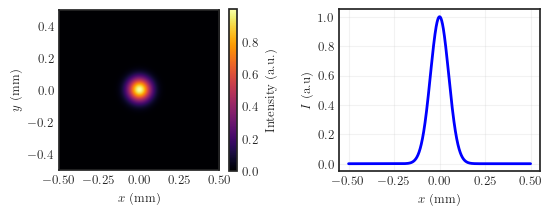

In [5]:
fig, ax = plt.subplots(1,2,figsize=(6.2, 2.1), gridspec_kw={'wspace': 0.4})

im = ax[0].imshow(I_in, extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear')
ax[0].set_xlabel(r'$x$ (mm)')
ax[0].set_ylabel(r'$y$ (mm)')
plt.colorbar(im, label='Intensity (a.u.)')

ax[1].plot(x_mm, slice_in / jnp.max(slice_in), label='Input', color='blue', linewidth=2)
ax[1].grid(alpha = 0.25)
ax[1].set_xlabel(r'$x$ (mm)')
ax[1].set_ylabel(r'$I$ (a.u)')

plt.tight_layout()
plt.savefig('initial_space_profile.png', dpi = 300, bbox_inches ='tight')
plt.show()

/tmp/ipykernel_1184/2396085306.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


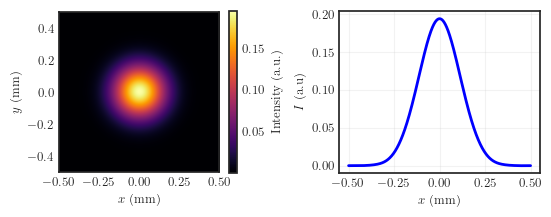

In [6]:
fig, ax = plt.subplots(1,2,figsize=(6.2, 2.1), gridspec_kw={'wspace': 0.4})

im = ax[0].imshow(I_out, extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear')
ax[0].set_xlabel(r'$x$ (mm)')
ax[0].set_ylabel(r'$y$ (mm)')
plt.colorbar(im, label='Intensity (a.u.)')

ax[1].plot(x_mm, slice_out / jnp.max(slice_in), label='Input', color='blue', linewidth=2)
ax[1].grid(alpha = 0.25)
ax[1].set_xlabel(r'$x$ (mm)')
ax[1].set_ylabel(r'$I$ (a.u)')
    
plt.tight_layout()
plt.savefig('final_space_profile.png', dpi = 300, bbox_inches ='tight')
plt.show()

# Spatio-Temporal Propagation

In [7]:
# --- Simulation Parameters ---

# Spatial
N_x = 256              # Number of spatial grid points
L = 1.0e-3              # Grid side length (2 mm)
w0 = 100e-6             # Initial beam waist (100 um)

# Temporal
N_t = 256               # Number of temporal grid points (can be smaller now)
T = 5.0e-12            # Total time window (10 ps)
tau_0 = 1.0e-12         # Pulse duration (1 ps)

# Wavelength / Frequency
wavelength_0 = 800e-9   # Central wavelength (800 nm)

# Propagation
z_R = (jnp.pi * w0**2) / wavelength_0
z_prop = 2.0 * z_R  # Propagate by 1 Rayleigh range
# --- Grid Setup ---
# Spatial
x = jnp.linspace(-L/2, L/2, N_x)
X, Y = jnp.meshgrid(x, x, indexing='ij') # (N_x, N_x)

# Temporal
dt = T / N_t
t = jnp.linspace(-T/2, T/2, N_t) # (N_t,)

# --- Create 3D (t, x, y) Grids ---
T_grid = t[:, None, None]     # Shape (N_t, 1, 1)
X_grid = X[None, :, :]        # Shape (1, N_x, N_x)
Y_grid = Y[None, :, :]        # Shape (1, N_x, N_x)

# --- Initial Field E(t, x, y) ---
# E = E_spatial * E_temporal_envelope
E_spatial = jnp.exp(-(X_grid**2 + Y_grid**2) / w0**2)

# --- KEY CHANGE ---
# We do *NOT* include the carrier exp(-i*omega_0*t)
E_temporal_env = jnp.exp(-T_grid**2 / (2 * tau_0**2))

E_in_txy = E_spatial * E_temporal_env
E_in_txy = E_in_txy.astype(jnp.complex128) # Ensure complex

t_vec = t

# We pass the central wavelength to the propagator now
E_out_txy = propagate_asm_spatiotemporal(
    E_in_txy, z_prop, L, T, wavelength_0, n_func=None
)

/home/juardilag/miniconda3/envs/work/lib/python3.14/site-packages/jax/_src/numpy/array_methods.py:125: UserWarning: Explicitly requested dtype complex128 requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [8]:
# Get intensities
I_in_txy = jnp.abs(E_in_txy)**2
I_out_txy = jnp.abs(E_out_txy)**2

vmax = I_out_txy.max()

x_mm = x * 1e3 # x-axis in mm

/tmp/ipykernel_1184/577074460.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


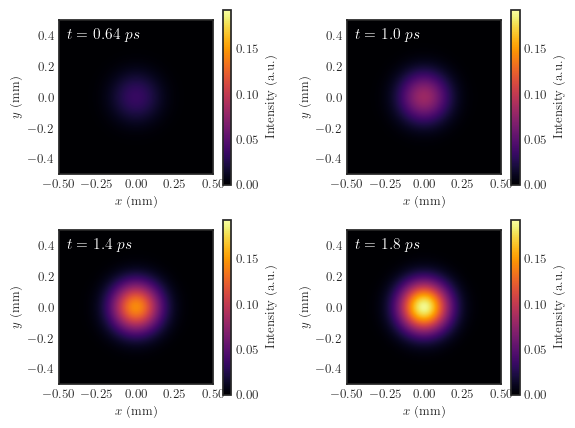

In [9]:
fig, ax = plt.subplots(2,2,figsize=(6.2, 5), gridspec_kw={'hspace': 0.2, 'wspace': 0.5})

im_1 = ax[0,0].imshow(I_out_txy[160,:,:], extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear',
                    vmin = 0, vmax = vmax)
ax[0,0].set_xlabel(r'$x$ (mm)')
ax[0,0].set_ylabel(r'$y$ (mm)')
ax[0,0].text(0.05, 0.95, r'$t={:.2} \ ps$'.format(t[160]*1e12), transform=ax[0,0].transAxes, 
             fontsize=11, color='white', va='top')
plt.colorbar(im_1, label='Intensity (a.u.)')

im_2 = ax[0,1].imshow(I_out_txy[180,:,:], extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear',
                    vmin = 0, vmax = vmax)
ax[0,1].set_xlabel(r'$x$ (mm)')
ax[0,1].set_ylabel(r'$y$ (mm)')
ax[0,1].text(0.05, 0.95, r'$t={:.2} \ ps$'.format(t[180]*1e12), transform=ax[0,1].transAxes, 
             fontsize=11, color='white', va='top')
plt.colorbar(im_2, label='Intensity (a.u.)')

im_3 = ax[1,0].imshow(I_out_txy[200,:,:], extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear',
                    vmin = 0, vmax = vmax)
ax[1,0].set_xlabel(r'$x$ (mm)')
ax[1,0].set_ylabel(r'$y$ (mm)')
ax[1,0].text(0.05, 0.95, r'$t={:.2} \ ps$'.format(t[200]*1e12), transform=ax[1,0].transAxes, 
             fontsize=11, color='white', va='top')
plt.colorbar(im_3, label='Intensity (a.u.)')

im_4 = ax[1,1].imshow(I_out_txy[220,:,:], extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], cmap='inferno', interpolation='bilinear',
                    vmin = 0, vmax = vmax)
ax[1,1].set_xlabel(r'$x$ (mm)')
ax[1,1].set_ylabel(r'$y$ (mm)')
ax[1,1].text(0.05, 0.95, r'$t={:.2} \ ps$'.format(t[220]*1e12), transform=ax[1,1].transAxes, 
             fontsize=11, color='white', va='top')
plt.colorbar(im_4, label='Intensity (a.u.)')
    
plt.tight_layout()
plt.savefig('spatio_temporal_propagation.png', dpi = 300, bbox_inches ='tight')
plt.show()

# Second Harmonic Generation

In [10]:
from asm import initialize_gaussian_pulse_3d, run_shg_simulation_with_history, normalize_field_to_energy

In [11]:
def get_n_o(delta_omega): 
    # This should be the Sellmeier for n_o at lambda1
    return 1.66  # Placeholder

def get_n_e(delta_omega):
    # This should be the Sellmeier for n_e(theta) at lambda2
    # If phase matched, n_e(2w) should be close to n_o(w)
    return 1.661 # Slight mismatch creates fringes

# 2. Simulation Params
L = 1e-3 # 1mm grid
T = 1000e-15 # 200 fs
dx = L / N_x
dt = T / N_t
N_x = 256
N_t = 256
w0 = 100e-6 # 100 micron beam
tau = 50e-15 # 50 fs pulse
d_eff = 2.0e-12 # 2 pm/V (Typical BBO value)
z_total = 2.5e-3 # 2 mm crystal

# 3. Initialize
E1_raw = initialize_gaussian_pulse_3d(N_t, N_x, L, T, w0=100e-6, tau=50e-15)

# 2. Rescale to Physical Units (e.g., 10 nanoJoules)
# This converts the amplitude from "1.0" to roughly "10^8 V/m"
E1_in = normalize_field_to_energy(E1_raw, energy_joules=10e-9, dx=dx, dt=dt, n=1.66)
E2_0 = jnp.zeros_like(E1_in) # Start with no SHG

E1_final, E2_final, U1_hist, U2_hist = run_shg_simulation_with_history(
    E1_in, E2_0, 
    L, T, 
    800e-9, # Fundamental
    get_n_o, # n1 function
    get_n_e, # n2 function
    d_eff, 
    z_total, 
    N_steps = 1_000 # Steps depends on nonlinearity strength. 
)

Rescaling input field by factor: 5.74e+07


/tmp/ipykernel_1184/2622070840.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


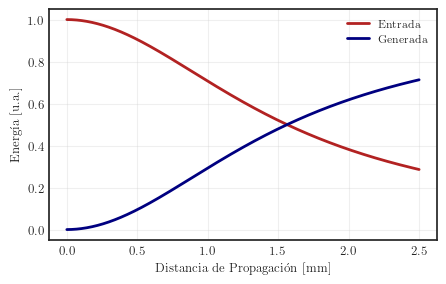

In [12]:
fig, ax = plt.subplots(figsize=(5.0, 3.0), gridspec_kw={'wspace': 0.4})

z_axis = jnp.linspace(0, z_total * 1000, len(U1_hist)) # Convert to mm

# Normalize to initial energy to see Efficiency (0 to 1.0)
initial_energy = U1_hist[0] + U2_hist[0]
norm_U1 = U1_hist / initial_energy
norm_U2 = U2_hist / initial_energy

plt.plot(z_axis, norm_U1, label='Entrada', color='firebrick', linewidth=2)
plt.plot(z_axis, norm_U2, label='Generada', color='navy', linewidth=2)

plt.xlabel("Distancia de Propagación [mm]")
plt.ylabel("Energía [u.a.]")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('energia_shg.png', dpi = 300, bbox_inches ='tight')
plt.show()

/tmp/ipykernel_1184/1335966772.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


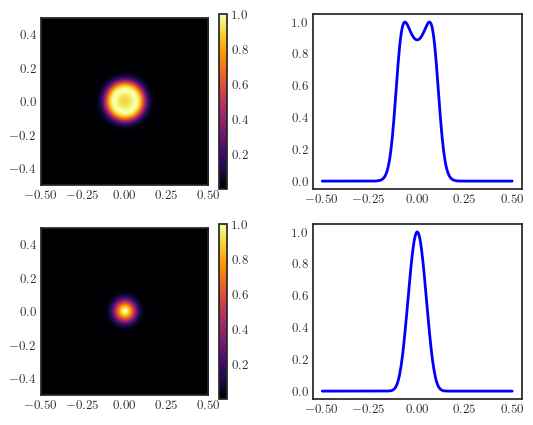

In [13]:
fig, ax = plt.subplots(2,2,figsize=(6.2, 5.0), gridspec_kw={'wspace': 0.3 })

input_map = jnp.sum(jnp.abs(E1_final)**2, axis=0)
im_1 = ax[0,0].imshow(input_map/jnp.max(input_map), 
           extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], 
           origin='lower',
           cmap='inferno')

output_map = jnp.sum(jnp.abs(E2_final)**2, axis=0)
im_2 = ax[1,0].imshow(output_map/jnp.max(output_map), 
           extent=[x_mm[0], x_mm[-1], x_mm[0], x_mm[-1]], 
           origin='lower',
           cmap='inferno')

Ny, Nx = input_map.shape
slice_in = input_map[Ny//2, :]
ax[0,1].plot(x_mm, slice_in / jnp.max(slice_in), label='Input', color='blue', linewidth=2)

slice_out = output_map[Ny//2, :]
ax[1,1].plot(x_mm, slice_out / jnp.max(slice_out), label='Input', color='blue', linewidth=2)

plt.colorbar(im_1)
plt.colorbar(im_2)

plt.tight_layout()
plt.savefig('final_profiles_SHG.png', dpi = 300, bbox_inches ='tight')
plt.show()

# SPDC

In [14]:
from asm import calculate_spdc_biphoton_state

In [ ]:
# --- SIMULATION SETUP ---
N = 80 # Keep small for 4D tensor (64^4 is ~16 million complex nums)
L_crystal = 2e-3  # 2 mm crystal
width_grid = 1e-3 # 1 mm grid
w0 = 100e-6       # 100 um pump waist

# Wavelengths (Degenerate SPDC)
lam_p = 405e-9    # Violet pump
lam_s = 810e-9    # IR signal
lam_i = 810e-9    # IR idler

# Refractive Indices (BBO Type I approximate)
# In reality, you use Sellmeier. Here we use scalars for demo.
n_p = 1.66
n_s = 1.66 # close to phase matching
n_i = 1.66 

# 1. Initialize Pump (Gaussian)
# Using your previous helper, or simple definition
x = jnp.linspace(-width_grid/2, width_grid/2, N)
X, Y = jnp.meshgrid(x, x)
Ep_spatial = jnp.exp(-(X**2 + Y**2)/w0**2).astype(jnp.complex128)

# 2. Run SPDC Calculation
print("Calculating 4D Biphoton Wavefunction...")
psi_4d, q_vec = calculate_spdc_biphoton_state(
    Ep_spatial, L_crystal, width_grid,
    lam_p, lam_s, lam_i,
    n_p, n_s, n_i
)

# Extract indices for the center (q=0)
mid = N // 2
# Slice: psi(qs_x, 0, qi_x, 0)
psi_slice_x = psi_4d[:, mid, :, mid]

prob_joint = jnp.abs(psi_slice_x)**2

Calculating 4D Biphoton Wavefunction...


/tmp/ipykernel_1184/1034616650.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


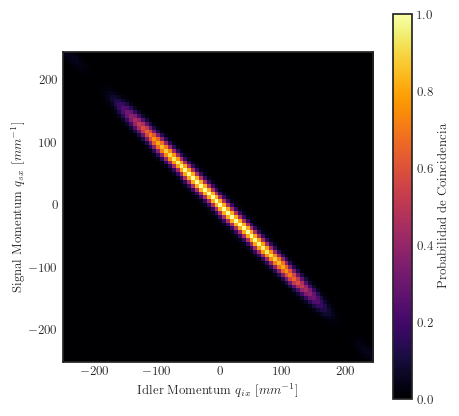

In [17]:
q_val = q_vec / 1e3

fig, ax = plt.subplots(figsize=(5.0, 5.0), gridspec_kw={'wspace': 0.3 })

ax = plt.imshow(prob_joint/jnp.max(prob_joint), extent=[q_val[0], q_val[-1], q_val[0], q_val[-1]], 
           origin='lower', cmap='inferno')

#plt.title(r"Transverse Momentum Correlations $|\psi(q_{sx}, q_{ix})|^2$")
plt.xlabel(r"Idler Momentum $q_{ix}$ [$mm^{-1}$]")
plt.ylabel(r"Signal Momentum $q_{sx}$ [$mm^{-1}$]")

plt.colorbar(ax, label="Probabilidad de Coincidencia")

plt.tight_layout()
plt.savefig('probabilidad_momento_spdc.png', dpi = 300, bbox_inches ='tight')
plt.show()

In [18]:
mid = psi_4d.shape[1] // 2
psi_slice = psi_4d[:, mid, :, mid]

# 2. Singular Value Decomposition
# matrix = U * S * Vh
# S contains the "weights" of each mode
U, S, Vh = jnp.linalg.svd(psi_slice)

# Normalize probabilities (sum of squares = 1)
eigenvalues = S**2
eigenvalues /= jnp.sum(eigenvalues)

# 3. Calculate Schmidt Number K
# K = 1 / sum(lambda^2)
K = 1.0 / jnp.sum(eigenvalues**2)

/tmp/ipykernel_1184/2992226130.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


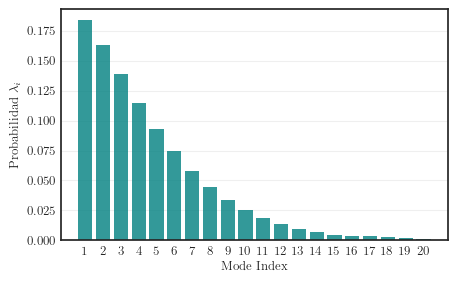

In [22]:
fig, ax = plt.subplots(figsize=(5.0, 3.0), gridspec_kw={'wspace': 0.4})

# Plot first 20 modes
modes = jnp.arange(1, 21)
plt.bar(modes, eigenvalues[:20], color='teal', alpha=0.8)

#plt.title(f"Schmidt Decomposition (Schmidt Number K = {K:.2f})")
plt.xlabel("Mode Index")
plt.ylabel(r"Probabilidad $\lambda_i$")
plt.xticks(modes)
plt.grid(True, axis='y', alpha=0.3)

# Inset or text for interpretation
#plt.text(10, 0.5 * jnp.max(eigenvalues), 
            #f"Interpretation:\nThe system behaves like\n~{int(round(K))} entangled\nmode pairs.",
            #bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('descomposicion_spdc.png', dpi = 300, bbox_inches ='tight')
plt.show()

In [20]:
# 1. Extract Momentum Slice again
mid = psi_4d.shape[1] // 2
psi_q_slice = psi_4d[:, mid, :, mid]

# 2. Inverse FFT to get Position Space
# We need to shift, ifft, then shift back for correct centering
psi_x_slice = jnp.fft.fftshift(jnp.fft.ifft2(jnp.fft.ifftshift(psi_q_slice)))

prob_x = jnp.abs(psi_x_slice)**2

# 3. Define Spatial Grid
N = psi_q_slice.shape[0]
x_vec = jnp.linspace(-width_grid/2, width_grid/2, N) * 1e3 # mm

/tmp/ipykernel_1184/1724700418.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


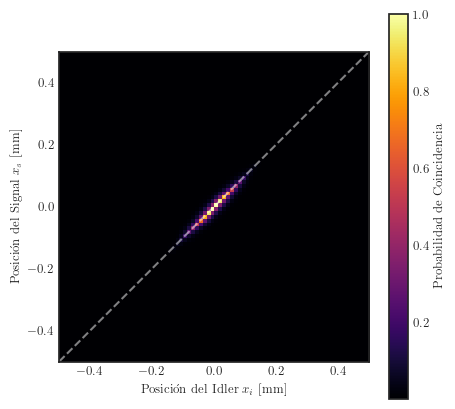

In [21]:
fig, ax = plt.subplots(figsize=(5.0, 5.0), gridspec_kw={'wspace': 0.3 })
plt.imshow(prob_x/jnp.max(prob_x), extent=[x_vec[0], x_vec[-1], x_vec[0], x_vec[-1]],
            origin='lower', cmap='inferno')

#plt.title(r"Near-Field Position Correlations $|\Psi(x_s, x_i)|^2$")
plt.xlabel("Posición del Idler $x_i$ [mm]")
plt.ylabel("Posición del Signal $x_s$ [mm]")
plt.colorbar(label="Probabilidad de Coincidencia")

# Guide line for x_s = x_i
plt.plot([x_vec[0], x_vec[-1]], [x_vec[0], x_vec[-1]], 'w--', alpha=0.5)

plt.tight_layout()
plt.savefig('probabilidad_espacial_spdc.png', dpi = 300, bbox_inches ='tight')
plt.show()